In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


In [5]:
nx.__version__

'2.1'

In [6]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import numpy.linalg as LA

from planning_utils import heuristic, create_grid
from planning_utils_graph import create_grid_and_edges, a_star_graph
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, Point, LineString

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

In [8]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [9]:
GRD = None

In [10]:
class MotionPlanning(Drone):

    def __init__(self, connection, GRD):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL
        
        self.GRD = GRD
        
        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        pass

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()

In [11]:
def main(GRD):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    if GRD is None:
        print("GRD is None")
    else:
        print("GRD is not None")
    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn, GRD)
    time.sleep(1)

    drone.start()
    if drone.GRD is not None:
        print("GRD = drone.GRD, not none")
        GRD = drone.GRD
    else:
        print("drone.GRD is none")
    return GRD

In [12]:
def plotgraphprob(grid, graph, start_ne=None, goal_ne=None, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, origin='lower', cmap='Greys') 

    for n1 in graph.nodes:
        plt.scatter(n1[1], n1[0], c='yellow', alpha=0.4, linewidths=5)
            
    # draw edges
    for (n1, n2) in graph.edges:
        plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black',linestyle='dashed' , alpha=0.5)
    
    if start_ne is not None:
        plt.plot(start_ne[1], start_ne[0], 'go', markersize=10, markeredgewidth=3, fillstyle='none')
    if goal_ne is not None:
        plt.plot(goal_ne[1], goal_ne[0], 'ro', markersize=10, markeredgewidth=3, fillstyle='none')

    if goal_list is not None:
        for g in goal_list:
            plt.plot(g[1], g[0], 'bd', markeredgewidth=2)

    if path is not None:
        if len(path) > 0:
            path_pairs = zip(path[:-1], path[1:])
            for (n1, n2) in path_pairs:
                plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'green',linewidth=4)
            plt.plot([path[-1][1], goal_ne[1]], [path[-1][0], goal_ne[0]],linewidth=4)
        
    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()

In [13]:
# Graph specific
def convert_graph(edges):
    G = nx.Graph()
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        dist = LA.norm(np.array(p2) - np.array(p1))
        G.add_edge(p1,p2,weight=dist)
    return G

In [14]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

In [15]:
# Probabilistic Roadmap
import time

class GridProbabilistic():
    def __init__(self, TARGET_ALTITUDE, SAFETY_DISTANCE):
        t_0 = time.time()
        self.TARGET_ALTITUDE = TARGET_ALTITUDE
        self.SAFETY_DISTANCE = SAFETY_DISTANCE
        
        self.gn_tree = None
        self.graph = None
        self.nodes = []
        
        self.n_steps = 1
        self.nk = 10
        self.n_poly = 2
        self.n_samples = 3000
        self.node_step = int(self.n_samples / self.n_steps)
        
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("grid# = {0}".format(len(grid)))
        print("grid shape = {0}".format(grid.shape))
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        with open('colliders.csv') as f:
            first_line = f.readline().strip()
        latlon = first_line.split(',')
        self.lon0 = float(latlon[0].strip().split(' ')[1])
        self.lat0 = float(latlon[1].strip().split(' ')[1])      

        self.grid = grid
        self.north_offset = north_offset
        self.east_offset = east_offset        

        self.polygons = self.extract_polygons(data)
        print("# Polygons:", len(self.polygons))
        
        self.centers = np.array([(p[0].centroid.x, p[0].centroid.y)for p in self.polygons])
        self.c_tree = KDTree(self.centers, metric="euclidean")

        self.xmin = 0.0
        self.xmax = float(grid.shape[0])
        self.ymin = 0.0
        self.ymax = float(grid.shape[1])
        
        self.zmin = 5.0
        # Limit the z axis for the visualization
        self.zmax = 5.0

        print("X | min = {0}, max = {1}".format(self.xmin, self.xmax))
        print("Y | min = {0}, max = {1}".format(self.ymin, self.ymax))
        print("Z | min = {0}, max = {1}".format(self.zmin, self.zmax))        

        t0 = time.time()      
        for step in range(self.n_steps):
            new_nodes = self.sample_nodes()
            self.create_graph(new_nodes)
            te = time.time()
            print("%s.step, #edges:%s, #nodes:%s, #snodes:%s, %.4f secs" %(step, len(self.graph.edges), len(self.graph.nodes), len(self.nodes), te-t0))
            # plotgraphprob(grid, self.graph)
        
        print("Number of edges", len(self.graph.edges))
        te = time.time()
        print('graph took {0} seconds to build, pre took {1}, all took {2}'.format(te-t0, t0 - t_0, te - t_0))


    def extract_polygons(self,data):

        polygons = []
        for i in range(data.shape[0]):
            north, east, alt, d_north, d_east, d_alt = data[i, :]

            # TODO: Extract the 4 corners of the obstacle
            # 
            # NOTE: The order of the points matters since
            # `shapely` draws the sequentially from point to point.
            #
            # If the area of the polygon is 0 you've likely got a weird
            # order.
            bottom = np.floor(north - d_north - self.SAFETY_DISTANCE - self.north_offset)
            top = np.ceil(north + d_north + self.SAFETY_DISTANCE - self.north_offset)
            left = np.floor(east - d_east - self.SAFETY_DISTANCE - self.east_offset)
            right = np.ceil(east + d_east + self.SAFETY_DISTANCE - self.east_offset)
            bottom_right = (bottom, right)
            top_right = (top, right)
            top_left = (top, left)
            bottom_left = (bottom, left)
            corners = [bottom_right,
                       top_right,
                       top_left,
                       bottom_left]

            # TODO: Compute the height of the polygon
            height = alt + d_alt + self.SAFETY_DISTANCE

            # TODO: Once you've defined corners, define polygons
            p = Polygon(corners)
            polygons.append((p, height))

        return polygons        
        
    def sample_nodes(self):
        # TODO: sample points randomly
        xvals = np.random.uniform(self.xmin, self.xmax, self.node_step)
        yvals = np.random.uniform(self.ymin, self.ymax, self.node_step)
        zvals = np.random.uniform(self.zmin, self.zmax, self.node_step)

        samples = list(zip(xvals, yvals, zvals))        
        nodes =[]
        n_collide_first = 0
        n_collide_other = 0
        n_collide_all = 0
        n_no_collide = 0
        
        for s in samples:
            #po = Point(s[0], s[1])
            sx = int(s[0])
            sy = int(s[1])
            po = Point(sx, sy)
            
            npo = np.array(Point(s[0], s[1])).reshape(1, -1)
            
            near_polies = self.c_tree.query(npo, k=self.n_poly, return_distance=False)[0]
            is_collision = False
            nidx = 0 
            for near_poly_idx in near_polies:
                nearp, nearph = self.polygons[int(near_poly_idx)]
                if nearp.contains(po):
                    if nearph > s[2]:
                        is_collision = True
                        n_collide_all += 1
                        if nidx > 0:
                            n_collide_other += 1
                            for npidx in near_polies:
                                if npidx != near_poly_idx:
                                    nearp2, nearph2 = self.polygons[int(npidx)]
                        else:
                            n_collide_first += 1
                        break
                nidx += 1
            if not is_collision:
                n_no_collide += 1
                #nodes.append(s)
                sz = int(s[2])
                nodes.append((sx, sy, sz))
        print("# samples, # nodes, # first, # other, # all, # no :", len(samples), len(nodes), n_collide_first, n_collide_other, n_collide_all, n_no_collide)
        # self.nodes = nodes
        return nodes
        
    def can_connect(self, p1, p2):
        line = LineString([p1, p2])
        for p in self.polygons:
            if line.crosses(p[0]) and p[1] >= min(p1[2], p2[2]):
                return False
        else:
            return True

    def create_graph(self, new_nodes):
        self.nodes = self.nodes + new_nodes
        tg0 = time.time()
        if self.graph is None:
            G = nx.Graph()
        else:
            G = self.graph
        n_tree = KDTree(self.nodes, metric="euclidean")
        print("tree build in %s sec", time.time() - tg0)
        self.n_tree = n_tree
        l = len(new_nodes)
        i = 0
        k = 2
        for p in new_nodes:
            neighbors = n_tree.query([p], k=self.nk, return_distance=True)

            for idx in range(1,neighbors[0].shape[1]):
                np_idx = neighbors[1][0][idx]
                neig_dist = neighbors[0][0][idx]
                np = self.nodes[np_idx]
                if p == np:
                    continue                    
                has_edge = G.has_edge(p,np)
                if has_edge:
                    continue
                if self.can_connect(p, np):
                    G.add_edge(p, np, weight=neig_dist)
            i += 1
            if (i % k == 0):
                print(i, "of", l, "gr:", len(G.nodes), " t:", time.time() - tg0)
                k = k * 2
                if k > l:
                    k == l
        self.graph = G

main
GRD is None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3974486   37.7924795    0.155    ], local position [-0.09646876  0.41409594 -0.15601018]
creating grid
grid# = 921
grid shape = (921, 921)
North offset = -316, east offset = -445
# Polygons: 3845
X | min = 0.0, max = 921.0
Y | min = 0.0, max = 921.0
Z | min = 5.0, max = 5.0
# samples, # nodes, # first, # other, # all, # no : 3000 1073 1920 7 1927 1073
tree build in %s sec 0.001550436019897461
2 of 1073 gr: 12  t: 0.7956545352935791
4 of 1073 gr: 29  t: 2.044138193130493
8 of 1073 gr: 65  t: 4.495099306106567
16 of 1073 gr: 124  t: 7.777703046798706
32 of 1073 gr: 208  t: 15.210421800613403
64 of 1073 gr: 390  t: 30.921647310256958
128 of 1073 gr: 652  t: 66.36864233016968
256 of 1073 gr: 890  t: 124.68821167945862
512 of 1073 gr: 1024  t: 227.56632828712463
1024 of 1073 gr: 1050  t: 361.322598695755
0.step, #e

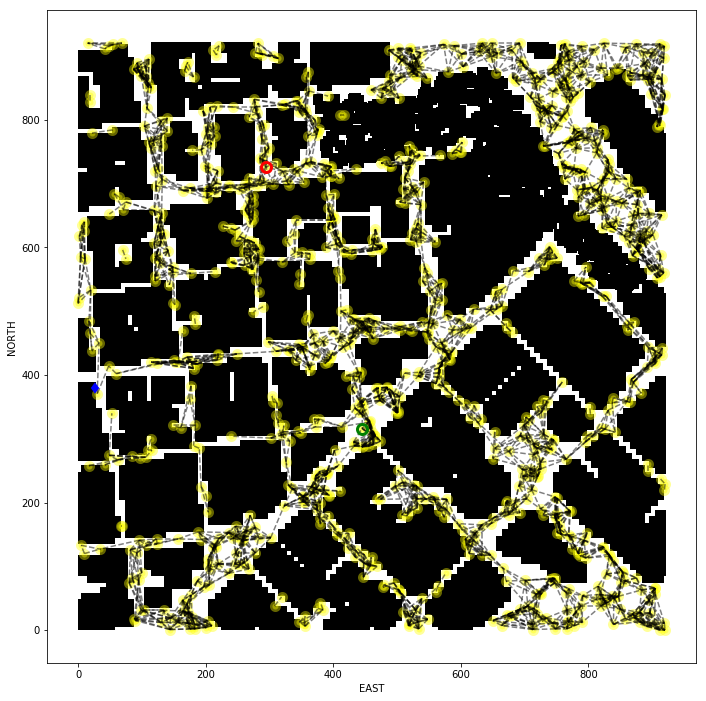

Grid Start and Goal:  (316, 445, 5) (726, 294, 5)
#Nodes:2, #Actions:0, Cost:439.01, HCost:412.99, Currenct Node:(342, 446, 5), Time:0.00
#Nodes:4, #Actions:0, Cost:447.06, HCost:430.08, Currenct Node:(328, 457, 5), Time:0.00
#Nodes:8, #Actions:0, Cost:477.25, HCost:452.55, Currenct Node:(295, 432, 5), Time:0.01
#Nodes:16, #Actions:0, Cost:878.89, HCost:407.43, Currenct Node:(360, 473, 5), Time:0.01
#Nodes:64, #Actions:0, Cost:1991.75, HCost:489.42, Currenct Node:(243, 373, 5), Time:0.03
#Nodes:128, #Actions:0, Cost:2663.06, HCost:418.00, Currenct Node:(424, 583, 5), Time:0.06
#Nodes:256, #Actions:0, Cost:3718.12, HCost:200.81, Currenct Node:(613, 460, 5), Time:0.11
Found a path.
#Nodes:286, #Actions:0, Cost:3846.88, HCost:0.00, Currenct Node:(726, 294, 5), Time:0.12
Path length: 17  cost: 3846.882613824345
Pruned Path length:  17


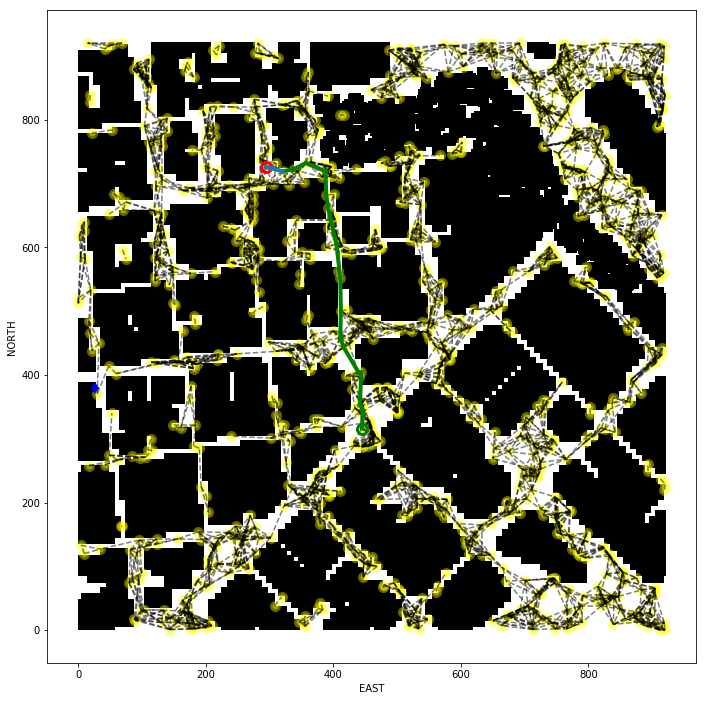

Sending waypoints to simulator ...
Closing connection ...
GRD = drone.GRD, not none


In [16]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 6

    self.target_position[2] = TARGET_ALTITUDE

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    
    if self.GRD is None:
        print("creating grid")
        self.GRD = GridProbabilistic(TARGET_ALTITUDE, SAFETY_DISTANCE)
    else:
        print("grid was already created")
        
    grid = self.GRD.grid
    north_offset = self.GRD.north_offset
    east_offset = self.GRD.east_offset
    lon0 = self.GRD.lon0
    lat0 = self.GRD.lat0
    
    # TODO: convert start position to current position rather than map center
    # TODO: set home position to (lon0, lat0, 0)
    self.set_home_position(lat0, lon0, 0)
    
    # TODO: retrieve current global position
    # TODO: convert to current local position using global_to_local()
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    north, east, att = local_pos
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("Grid Start: ",grid_start)
    
    dist_idx = 100.0
    goal_obs = True
    goal_try = 0
    goal_list = []
    grid_shape = grid.shape
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_home[0] + change[0] / dist_idx,
                self.global_home[1] + change[1] / (dist_idx),
                self.global_home[2] + change[2] * 10.0)
        print("Goal Global: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("Goal Local: ", local_goal)
        ng, eg, ag = local_goal

        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        # grid_goal = (616, 556)

        if grid_goal[0] >= grid_shape[0]:
            grid_goal = (grid_shape[0] - 1, grid_goal[1])
        elif grid_goal[0] < 0:
            grid_goal = (0, grid_goal[1])            
        if grid_goal[1] >= grid_shape[1]:
            grid_goal = (grid_goal[0], grid_shape[1] - 1)
        elif grid_goal[1] < 0:
            grid_goal = (grid_goal[0], 0)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        print("gg: ",grid_goal, goal_obs)
        if goal_obs:
            goal_list.append(grid_goal)
            
    if len(grid_start) == 2:
        grid_start = (grid_start[0], grid_start[1] , TARGET_ALTITUDE)
        grid_goal = (grid_goal[0], grid_goal[1] , TARGET_ALTITUDE)
        
    self.GRD.create_graph([grid_start, grid_goal])
    
    
    graph = self.GRD.graph
    nodes = self.GRD.nodes
  
    plotgraphprob(grid, graph, grid_start, grid_goal, goal_list=goal_list)
    print('Grid Start and Goal: ', grid_start, grid_goal)    
    
    path, cost = a_star_graph(graph, heuristic, grid_start, grid_goal)
    print("Path length:", len(path)," cost:", cost)
    # plotgraphprob(grid, graph, grid_start, grid_goal, goal_list=goal_list, path=path)
    
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!
    pruned_path = prune_path(path)
    print("Pruned Path length: ", len(pruned_path))
    plotgraphprob(grid, graph, grid_start, grid_goal, goal_list=goal_list, path=pruned_path)

    # print("A* path:")
    # for p in path:
    #     print(p)
        
    # print("Pruned_path:")
    # for p in pruned_path:
    #     print(p)


    waypoints = [[int(np.rint(p[0] + north_offset)), int(np.rint(p[1] + east_offset)), TARGET_ALTITUDE, 0] for p in pruned_path]

    # print("waypoints")
    # print(waypoints)
    # for w in waypoints:
    #    print(w)

    # Set self.waypoints
    self.waypoints = waypoints
    self.GRD.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
GRD = main(GRD)

In [17]:
# send waypoints directly
def plan_path_send_wp(self):
    self.flight_state = States.PLANNING

    if self.GRD is not None:
        if self.GRD.waypoints is not None:
            waypoints = self.GRD.waypoints
    
    print("waypoints")
    print(waypoints)
    for w in waypoints:
        print(w)
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path_send_wp
GRD = main(GRD)
MotionPlanning.plan_path = plan_path

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
waypoints
[[0, 0, 5, 0], [26, 1, 5, 0], [42, -3, 5, 0], [88, -1, 5, 0], [89, -6, 5, 0], [128, -29, 5, 0], [142, -34, 5, 0], [184, -33, 5, 0], [236, -34, 5, 0], [289, -40, 5, 0], [327, -49, 5, 0], [345, -53, 5, 0], [366, -56, 5, 0], [403, -57, 5, 0], [416, -88, 5, 0], [407, -106, 5, 0], [403, -124, 5, 0]]
[0, 0, 5, 0]
[26, 1, 5, 0]
[42, -3, 5, 0]
[88, -1, 5, 0]
[89, -6, 5, 0]
[128, -29, 5, 0]
[142, -34, 5, 0]
[184, -33, 5, 0]
[236, -34, 5, 0]
[289, -40, 5, 0]
[327, -49, 5, 0]
[345, -53, 5, 0]
[366, -56, 5, 0]
[403, -57, 5, 0]
[416, -88, 5, 0]
[407, -106, 5, 0]
[403, -124, 5, 0]
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [26, 1, 5, 0]
waypoint transition
target position [42, -3, 5, 0]
waypoint transition
target position [88, -1, 5, 0]
waypoint transition
target position [89, -6, 5, 0]
waypoint transition
t

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.3988432   37.7961093    0.129    ], local position [ 4.03208588e+02 -1.23552620e+02 -1.30105063e-01]
grid was already created
Grid Start:  (718, 320)
change [0.31612025 0.38561783 0.23794213]
Goal Global:  (-122.39429209749787, 37.79633657832159, 2.379421324024343)
Goal Local:  [429.64049369 275.55738607  -2.37942132]
gg:  (746, 721) 1.0
change [ 0.3616255  -0.13084793 -0.05211619]
Goal Global:  (-122.39383704496461, 37.79117192067771, -0.5211618685031705)
Goal Local:  [-143.11726811  319.33580375    0.52116187]
gg:  (173, 764) 0.0
tree build in %s sec 0.0032122135162353516
2 of 2 gr: 1055  t: 2.2493035793304443


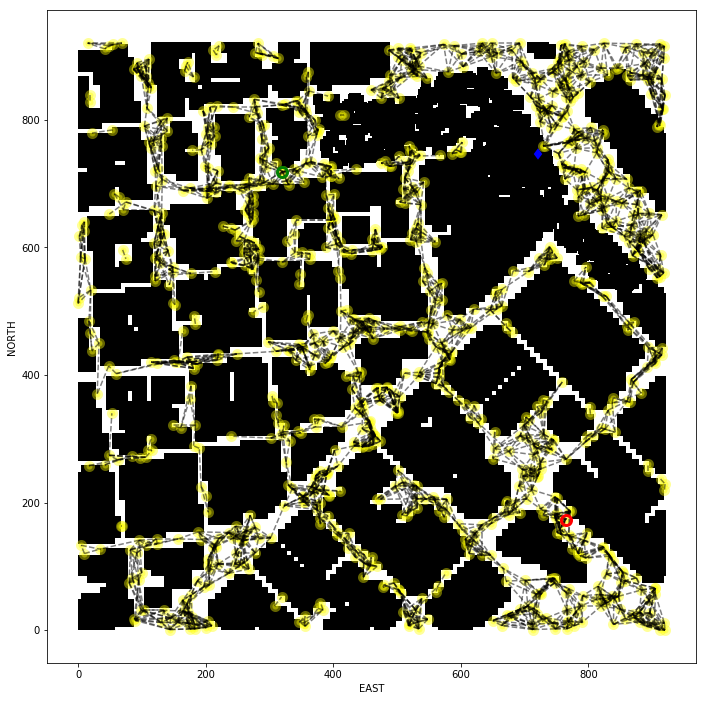

Grid Start and Goal:  (718, 320, 5) (173, 764, 5)
#Nodes:2, #Actions:0, Cost:703.35, HCost:687.70, Currenct Node:(704, 327, 5), Time:0.00
#Nodes:4, #Actions:0, Cost:704.53, HCost:703.11, Currenct Node:(719, 321, 5), Time:0.00
#Nodes:8, #Actions:0, Cost:742.50, HCost:708.88, Currenct Node:(701, 291, 5), Time:0.01
#Nodes:16, #Actions:0, Cost:1427.39, HCost:688.42, Currenct Node:(734, 365, 5), Time:0.01
#Nodes:32, #Actions:0, Cost:2085.66, HCost:662.94, Currenct Node:(719, 388, 5), Time:0.02
#Nodes:64, #Actions:0, Cost:2996.21, HCost:763.03, Currenct Node:(812, 347, 5), Time:0.03
#Nodes:128, #Actions:0, Cost:4858.37, HCost:848.13, Currenct Node:(822, 218, 5), Time:0.06
#Nodes:256, #Actions:0, Cost:7159.78, HCost:480.81, Currenct Node:(450, 371, 5), Time:0.12
Found a path.
#Nodes:486, #Actions:0, Cost:9603.86, HCost:0.00, Currenct Node:(173, 764, 5), Time:0.23
Path length: 24  cost: 9603.856252848362
Pruned Path length:  24


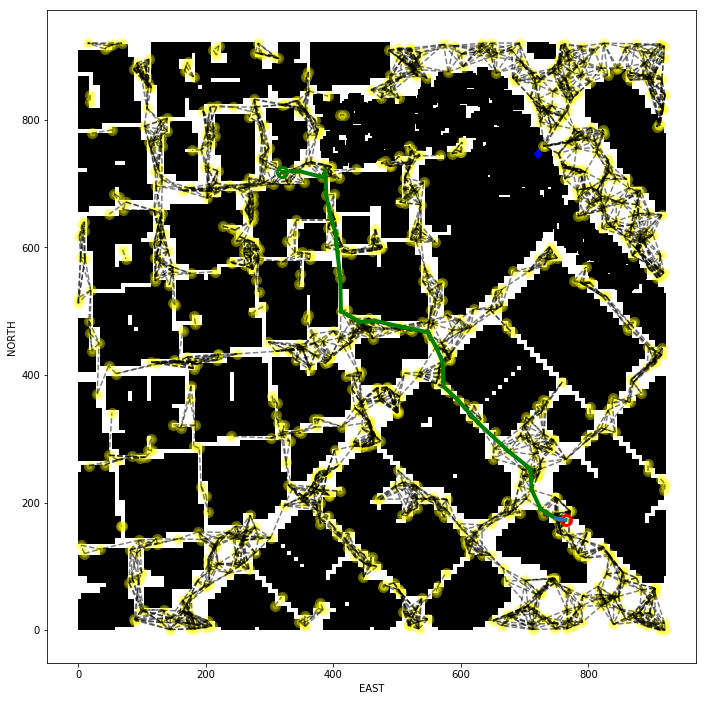

Sending waypoints to simulator ...
Closing connection ...
GRD = drone.GRD, not none


In [18]:
GRD = main(GRD)

In [19]:
MotionPlanning.plan_path = plan_path_send_wp
GRD = main(GRD)
MotionPlanning.plan_path = plan_path

main
GRD is not None
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
waypoints
[[402, -125, 5, 0], [404, -101, 5, 0], [394, -62, 5, 0], [403, -57, 5, 0], [366, -56, 5, 0], [331, -49, 5, 0], [303, -40, 5, 0], [289, -40, 5, 0], [236, -34, 5, 0], [184, -33, 5, 0], [167, -3, 5, 0], [169, 20, 5, 0], [160, 59, 5, 0], [151, 103, 5, 0], [128, 116, 5, 0], [105, 126, 5, 0], [66, 128, 5, 0], [45, 150, 5, 0], [9, 182, 5, 0], [-36, 230, 5, 0], [-63, 264, 5, 0], [-96, 266, 5, 0], [-126, 280, 5, 0], [-141, 304, 5, 0]]
[402, -125, 5, 0]
[404, -101, 5, 0]
[394, -62, 5, 0]
[403, -57, 5, 0]
[366, -56, 5, 0]
[331, -49, 5, 0]
[303, -40, 5, 0]
[289, -40, 5, 0]
[236, -34, 5, 0]
[184, -33, 5, 0]
[167, -3, 5, 0]
[169, 20, 5, 0]
[160, 59, 5, 0]
[151, 103, 5, 0]
[128, 116, 5, 0]
[105, 126, 5, 0]
[66, 128, 5, 0]
[45, 150, 5, 0]
[9, 182, 5, 0]
[-36, 230, 5, 0]
[-63, 264, 5, 0]
[-96, 266, 5, 0]
[-126, 280, 5, 0]
[-141, 304, 5, 0]
Sending waypoints to simulator ...
takeoff transition
waypoint tra